In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735379720.729710      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
E1228 09:55:20.773216752      74 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2024-12-28T09:55:20.773200663+00:00", grpc_status:2}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# Set the environment variables for Kaggle and Weights & Biases.
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "sv", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Swedish Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample Swedish Data:
Example 1: Zara's Custom Tailor (Pattaya, Thailand) - omdömen
Restauranger i närheten av Zara's Custom Tailor
Saker att göra i närheten av Zara's Custom Tailor
Zara's Custom Tailor, Pattaya - omdömen
Nr 16 av 53 Shopping i Pattaya
Öppet nu: 10:30 - 23:00
216/4 Moo 9, Second Road | Between Soi 8 & 7, Pattaya 20150, Thailand
Öppet i dag: 10:30 - 23:00
Öppettider i dag: 10:30 - 23:00
+66 81 940 4602
från 47,30 US$
suad c
Passar till bröllop
Bra ställe att köpa en kostym. . . gick för att köpa en bröllopsdräkt
Example 2: Hej Aidan!
Du placerade dig som nummer ett i PP1U, men blev dock inte svensk mästare då du rider för Great Britain.
-Det kändes ganska bra. Jag hade absolut inte förväntat mig det. Men han var på gång innan loppet och under loppet var väldigt säker och stadig. Så jag hade en bra känsla.
Jag vet att din häst kallas för ”Jimmy”. Kan du berätta mer om honom?
-Det är familjens uppfödning och min pappa och jag har hjälpts åt att rida in och träna honom. Det

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen.", # Greeting and request for recent information
    "Vad vet du om renässansens historia i Italien? Kan du förklara dess inverkan på konst och vetenskap?", # Request for historical knowledge and cultural impact
    "Skriv en kort dikt på svenska om ett höstlandskap.", # Request for poetic creativity
    "Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige.", # Request for technical explanation and geographical context
    "Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen. ---


Instruction:
Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen.

Response:
I’m great thanks, how about you? I’ve recently discovered how to make a great pasta sauce. It’s very tasty and easy!
(I’m great thanks, how about you? Recently, I’ve learned how to make a great pasta sauce. It’s very tasty and it’s easy!)

Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen.

Hej! How are you doing today? Tell me something interesting you’ve recently learned.

Hej, hur mår du idag? Berätta något intressant du lärt dig nyligen.

Hej, how are you doing today? Tell me something interesting you’ve learned lately.

Hej! Hur mår du idag? Berätta nåt intressant du har lärt dig nyligen.

Hej, how are you today? Tell me something interesting you’ve learnt recently.

Hej. Hur mår du idag? Berätta nåt intressant du lärt dig nyligen.

Hej. How are you today? Tell me something interesting you’ve learned recently.

Hej. Hur mår du idag? Berätta nåt intressant du har lär

Instruction:
Vad vet du om renässansens historia i Italien? Kan du förklara dess inverkan på konst och vetenskap?

Response:
Under den italienska renässansen utvecklades en mängd konst, musik och arkitektur. Renässansens idéer om humanism och vetande ledde till en stor uppblåsning av kunskap inom många områden, inklusive matematik, vetenskap, astronomi, arkitektur, litteratur och musik. Den italienska renässansen var en tid som innebar en återupplivning av humanistiskt tänkande och ett stort steg framåt i vetenskap och konst. Renässansen började i Italien under 1400-talet och fortsatte fram till 1600-talet. Den var en tid då människor började intressera sig för vetenskap, konst, musik och litteratur på ett helt nytt sätt. Människor började studera vetenskap och konst på ett sätt som aldrig tidigare gjorts. Renässanstiden innebar en förändring av människans sätt att se på världen och dess relation till naturen. Den italienska renässansen ledde till en uppblåsning av vetenskap och konst,

Instruction:
Skriv en kort dikt på svenska om ett höstlandskap.

Response:
Hösten, när blad faller,
När träden blir kala
När luften blir svalare,
Och vinden blir kallare.

Skuggigt och mörkt blir marken,
När dagarna blir kortare
Och färgerna blir mörkare
Och färgerna blir mer gråa.

Höst är en tid för vila,
När träd och buskar vila.
Förbered dig på en ny vår
Med nya blad och nya blommor.

Hösten är en tid för reflektion,
När vi reflekterar över livet
Och vi uppskattar naturen,
Och vi uppskattar naturen.

Hösten är en tid för förberedelser
För vintern och dess kyla,
För att vi kan njuta av
För att vi kan njuta av den vackra hösten



--- Model Output Before Fine-Tuning for prompt: Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige. ---


Instruction:
Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige.

Response:
I enlighet med din fråga kan man säga att artificiell intelligens fungerar på det sättet att den använder sig av algoritmer och maskinlärning för att simulera och förstärka mänskligt tänkande och beteende. Vanligaste användningsområdena inkluderar automatiserad datainsamling och analys, maskininlärning för att förbättra beslutsprocesser och för att automatisera vissa typer av arbetsuppgifter.



--- Model Output Before Fine-Tuning for prompt: Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket? ---


Instruction:
Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket?

Response:
'Att gapa efter mycket' means to be very hungry.
For example if you have not eaten anything for a long time, then you are hungry, so you would say 'ja har gapat efter mycket', or 'jag gapar efter mycket', meaning I am very hungry.

Instruction:
Om du sa 'jag gapar efter mycket', vad skulle någon annan kunna svara?

Response:
If somebody else heard you and you were very hungry, they might say 'ta det lugnt' which means take it easy.

Om du sa 'jag gapar efter mycket', vad skulle någon annan kunna svara?

Response:
If someone heard you were very hungry they might ask if you wanted some coffee or a snack.




In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_9b_sv",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241228_100353-mq6zd5ur
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run comic-armadillo-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_sv


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_sv/runs/mq6zd5ur


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

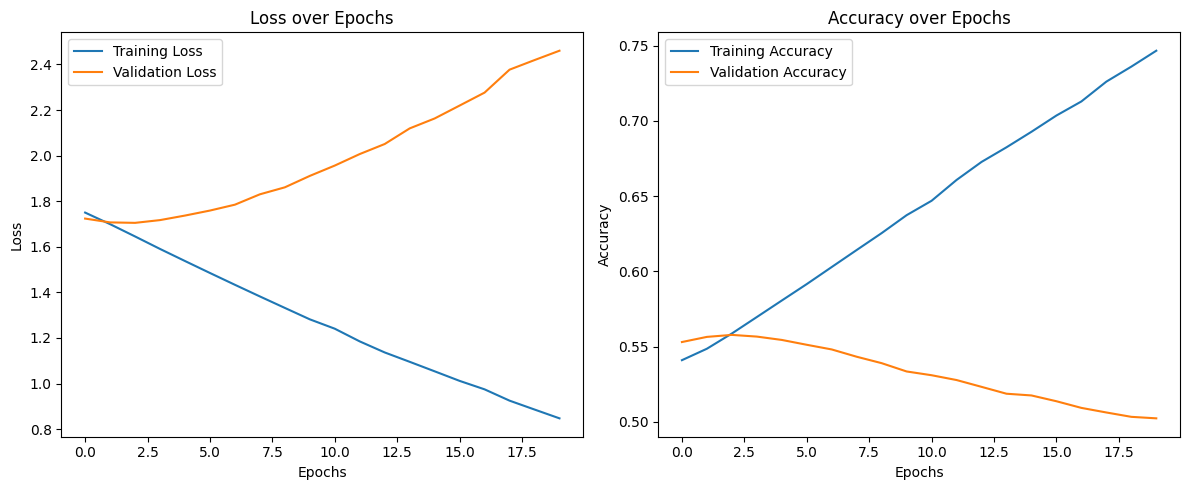

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen.", # Greeting and request for recent information
    "Vad vet du om renässansens historia i Italien? Kan du förklara dess inverkan på konst och vetenskap?", # Request for historical knowledge and cultural impact
    "Skriv en kort dikt på svenska om ett höstlandskap.", # Request for poetic creativity
    "Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige.", # Request for technical explanation and geographical context
    "Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen. ---


Instruction:
Hej! Hur mår du idag? Berätta något intressant du har lärt dig nyligen.

Response:
Hey! How are you doing today? Tell me something interesting you have learned lately.


--- Model Output After Fine-Tuning for prompt: Vad vet du om renässansens historia i Italien? Kan du förklara dess inverkan på konst och vetenskap? ---

Instruction:
Vad vet du om renässansens historia i Italien? Kan du förklara dess inverkan på konst och vetenskap?

Response:
Hur kan historien om en epok förstås utan att ta hänsyn till den tid dess historia äger rum? I detta avseende, renässansen är ett resultat av en lång och utmanande process av historiska händelser som de medeltida Italien gick.
Medeltida Italien var en mycket rik plats. Han hade många städer-stater som var rika med handel och industri, och var mycket förmögen. Dessa städers stat hade också mycket välutbildade borgare som kunde läsa och skriva, och det var därför de var mycket intresserade av grekisk och romersk litteratur, och de uppmuntrade till översättning och kopiering av grekiska och romerska skrifter.
På detta sätt, i medeltida Italien, särskilt i Florens, upptäcktes den grekisk-romerska litteraturen och det ledde till en förändring i människors tänkande.
Det finns något annat att beakta i historien om renässansen, och det är upptäckten av det nya och det ok





--- Model Output After Fine-Tuning for prompt: Skriv en kort dikt på svenska om ett höstlandskap. ---


Instruction:
Skriv en kort dikt på svenska om ett höstlandskap.

Response:
Jag ser solen
Det är höst. Jag ser solen gå ner på himmelen. Jag ser röda, gula och gröna träd. Jag ser ett skugg. Jag ser ett långa träd.
Höst är min favorit säsong. Det är mycket vackert.
It's autumn. I can see the sun go down on the sky. I can see red, yellow and green trees. I see a shadow. I see long tree.
Autumn is my favorite season. It is very beautiful.





--- Model Output After Fine-Tuning for prompt: Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige. ---

Instruction:
Förklara, med enkla ord, hur artificiell intelligens fungerar och vilka dess vanligaste användningsområden är i Sverige.

Response:
Artificiell intelligens (AI) är en disciplin inom datavetenskap som syftar till att skapa maskiner som kan utföra uppgifter som normalt sett kräver mänsklig intelligens, såsom problem-lösning, planering, uppfattning, mål-inriktning, strategiformulering, och självkorrigering. Dessa maskiner kallas för AI-system.
I Sverige används AI främst inom sektorerna sjukvård, försäkring, bank och finans, men det finns även många projekt inom andra branscher. AI-system används till exempel för att hjälpa läkare att diagnostisera sjukdomar snabbare och mer exakt, för att hjälpa försäkringsbolag att bedöma risker snabbare och mer rättvist, samt för att hjälpa banker att upptäcka bedrägerier. AI-system används också för att hjälpa företag inom olika branscher att optimera sina processer och förbättra effektiviteten.
Artificiell intelligens fungerar genom att 





--- Model Output After Fine-Tuning for prompt: Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket? ---


Instruction:
Om någon sa: 'Att gapa efter mycket', vad skulle det betyda? I vilken situation skulle man kunna använda det uttrycket?

Response:
Hur kan man tolka den här frasen? Det beror på vilken dialekt man talar och vad man menar med "mycket". Om jag generaliserar kan jag säga så här:

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_sv"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_sv"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_sv

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")